# Install packages

In [46]:
###
###
# install requirements
###
###

# Import packages

In [290]:
import random
import numpy as np
import pandas as pd
import re
import tqdm
from nltk import FreqDist

from sklearn.base import BaseEstimator, TransformerMixin

from hazm import Normalizer, Stemmer, Lemmatizer
from hazm import WordTokenizer, SentenceTokenizer
import emoji

# Data loading

In [241]:
tehran_posts = pd.read_csv('data/tehran-apartment-sell-posts.csv')
mashhad_posts = pd.read_csv('data/mashhad-apartment-sell-posts.csv')
isfahan_posts = pd.read_csv('data/isfahan-apartment-sell-posts.csv')
ardabil_posts = pd.read_csv('data/ardabil-apartment-sell-posts.csv')

In [254]:
tehran_posts['city'] = 'tehran'
mashhad_posts['city'] = 'mashhad'
isfahan_posts['city'] = 'isfahan'
ardabil_posts['city'] = 'ardabil'

In [255]:
posts = pd.concat([tehran_posts, mashhad_posts, isfahan_posts, ardabil_posts], ignore_index=True)

# Clean data

In [256]:
posts.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description,city
0,63,1375,1,False,False,True,دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب....,۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
1,180,1393,3,True,True,True,دقایقی پیش در تهران، شیان | فروش آپارتمان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
2,38,1380,1,False,False,True,دقایقی پیش در تهران، پلیس | فروش آپارتمان,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
3,88,1384,2,True,True,True,دقایقی پیش در تهران، تهران‌نو | فروش آپارتمان,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
4,40,1393,1,True,True,True,دقایقی پیش در تهران، بریانک | فروش آپارتمان,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran


In [257]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268 entries, 0 to 2267
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Area          2268 non-null   object
 1   Construction  2268 non-null   object
 2   Room          2268 non-null   object
 3   Warehouse     2268 non-null   object
 4   Parking       2268 non-null   object
 5   Elevator      2268 non-null   object
 6   Address       2268 non-null   object
 7   Price         2268 non-null   object
 8   Description   2268 non-null   object
 9   city          2268 non-null   object
dtypes: object(10)
memory usage: 177.3+ KB


In [264]:
for desc in random.sample(list(posts.Description.values), 5):
    print(desc)
    print('#'*100)

<p class="kt-description-row__text kt-description-row__text--primary">⚜⚜مشاورین املاک خانه نو⚜⚜
✅کارشناس :آقای سلطانی 
____________________________________________
✅۱۹۵ متر
✅۳ خواب (یکیش‌مستر)
✅طبقه ۲
✅تک واحدی 
✅فوق العاده شیک و لوکس
✅شخصی ساز با بهترین متریال روز 
✅نقشه و ساخت در خور تحسین 
✅روف گاردن (بام سبز ) همراه با آلاچیق وباربیکو 
✅سیستم تهویه چیلر مرکزی ، کف سرامیک اسلب
✅آسانسور ۸ نفره / لابی ورودی مجلل و شیک 
✅دارای ۳ عدد تراس و ۲ عدد پارکینگ 
✅نمونه ای کم نظیر در منطقه 

✅فروشنده واقعی 
✅فروش فوری و نقدی !!

⭐بازدید این ملک را از دست ندهید 

✅موارد مشابه موجود میباشد. 
____________________________________________
❌لطفا مشاور املاک تماس نگیرد❌</p>
####################################################################################################
<p class="kt-description-row__text kt-description-row__text--primary">✅آپارتمان ۱۱۷ متری ۲ خواب
✅فول امکانات (آسانسور،پارکینگ،انباری)
✅لوکیشن خوب 
✅دسترسی عالی 
✅متریال عالی
✅خوش نقشه 
✅مهندسی ساز
✅سالنی پرده خور با پنجره های قدی
✅ن

### Clean Address feature

In [265]:
posts.Address[0]

'دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب. ایت الله سعیدی) | فروش آپارتمان'

In [266]:
class extractAddressTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.Address = X.Address.apply(
            lambda adress: '،'.join(adress.split('|')[0].split('،')[1:])
        )
        return X

In [267]:
t = extractAddressTransformer()

In [268]:
posts = t.fit_transform(posts)

In [269]:
posts.Address[0]

' شمشیری، خیابان شمشیری (ب. ایت الله سعیدی) '

### Clean Description feature

In [270]:
posts.Description[1]

'<p class="kt-description-row__text kt-description-row__text--primary">برج باغ با موقعیت دنج و آرام/ چشم انداز پارک جنگلی و قله دماوند/ 3خواب، یک مستر/ لابی بزرگ/ سرایدار مقیم/ بالکن مفید/ ژنراتور برق/ چیلر مرکزی/ اطفای حریق/دوربین مداربسته/ بدون دیوار مشترک/ نورگیر از شمال، شرق و غرب واحد/ حیاط بزرگ و مشجر با آبنما، آلاچیق و چاه آب/ روف گاردن/ پیاده تا پارک جنگلی ده دقیقه.\nلطفا املاک تماس نگیرند.</p>'

In [271]:
class removeTagTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cleanre = re.compile('<.*?>') 
        return self
    def transform(self, X):
        X.Description = X.Description.apply(
            lambda desc: re.sub(self.cleanre, '', desc)
        )
        return X

In [272]:
t = removeTagTransformer()
posts = t.fit_transform(posts)

In [273]:
posts.Description[1]

'برج باغ با موقعیت دنج و آرام/ چشم انداز پارک جنگلی و قله دماوند/ 3خواب، یک مستر/ لابی بزرگ/ سرایدار مقیم/ بالکن مفید/ ژنراتور برق/ چیلر مرکزی/ اطفای حریق/دوربین مداربسته/ بدون دیوار مشترک/ نورگیر از شمال، شرق و غرب واحد/ حیاط بزرگ و مشجر با آبنما، آلاچیق و چاه آب/ روف گاردن/ پیاده تا پارک جنگلی ده دقیقه.\nلطفا املاک تماس نگیرند.'

# Preprocess

### Remove imojies

In [231]:
class DescriptionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.column_name] = X[self.column_name].apply(
            lambda text: emoji.get_emoji_regexp().sub(r'', text)
        )
        return X

### Description Transformer

In [154]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def isEnglish(s):
    return s.lower().islower()

In [171]:
class DescriptionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        stop_words_file = open("stopwords.txt", "r")
        content = stop_words_file.read()
        self.stopwords = content.split("\n")
        
        self.normalizer = Normalizer()
        self.lemmatizer = Lemmatizer()
        
        self.tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True, replace_numbers=True)
        return self
    
    def transform(self, X):
        cleaned = []
        
        for text in X[self.column_name]:
            # tokenize - replace link-number
            words = self.tokenizer.tokenize(' '.join(self.tokenizer.tokenize(text)))
            # replace ي with ی and remove arabic symbols
            words = [self.normalizer.character_refinement(word) for word in words]

            words = [word for word in words if not isEnglish(word)]
#             words = [word for word in words if not hasNumbers(word)]

            text = ' '.join([self.lemmatizer.lemmatize(word) for word in words])
            cleaned.append(text)
        
        X[self.column_name] = cleaned
        return X

In [156]:
desc_transformer = DescriptionTransformer(column_name='Description')

In [157]:
posts = desc_transformer.fit_transform(posts)

In [158]:
posts

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description
0,63,1375,1,False,False,True,شمشیری، خیابان شمشیری (ب. ایت الله سعیدی),۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,دونبش تک واحد سه غرق نور دسترس لوکیشن عالی باز...
1,180,1393,3,True,True,True,شیان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,برج باغ موقعیت دنج آرام/ چشم انداز پارک جنگل ق...
2,38,1380,1,False,False,True,پلیس,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,اپارتمان متری پلیس-کلیم کاشان تکواحدی طبقه انب...
3,88,1384,2,True,True,True,تهران‌نو,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,مشاورین املاک یونس آدرس املاک فلکه چایچی سفیدک...
4,40,1393,1,True,True,True,بریانک,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,هوالرزاق بربانک ابراهیم حسینی متر تک خواب طبقه...
...,...,...,...,...,...,...,...,...,...
1354,87,1396,2,True,True,True,بهارستان,۱٬۰۸۰٬۰۰۰٬۰۰۰ تومان,سلام اپارتمان متری خوابه مسکن مهر جنوبی پرنور ...
1355,130,1401,3,True,True,True,آفاران,۲٬۸۰۰٬۰۰۰٬۰۰۰ تومان,املاک آسمان آب مشاور عزیز انواع ملک تماس عزیز ...
1356,122,1393,2,True,True,True,اشراق,۲٬۷۰۰٬۰۰۰٬۰۰۰ تومان,آپارتمان واحد نور عالی ۵طبقه واحد-متراژ متر-طب...
1357,105,1389,2,True,True,True,خانه اصفهان,۲٬۷۰۰٬۰۰۰٬۰۰۰ تومان,واقع لوکیشن خانه اصفهان دسترس عالی جنوبی فول ا...


# Remove stopwords transformer

In [169]:
class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        stop_words_file = open("stopwords.txt", "r")
        content = stop_words_file.read()
        self.stopwords = content.split("\n")
        
        self.tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True, replace_numbers=True)
        return self
    
    def transform(self, X):
        cleaned = []
        
        for text in X[self.column_name]:
            words = self.tokenizer.tokenize(' '.join(self.tokenizer.tokenize(text)))
            words = [word for word in words if word not in self.stopwords]

            text = ' '.join(words)
            cleaned.append(text)
        
        X[self.column_name] = cleaned
        return X

# Notebook body

In [274]:
normalizer = Normalizer()
posts.Description = [normalizer.normalize(desc) for desc in tqdm.tqdm(posts.Description)]

100%|██████████| 2268/2268 [00:00<00:00, 8042.38it/s]


In [275]:
posts.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description,city
0,63,1375,1,False,False,True,شمشیری، خیابان شمشیری (ب. ایت الله سعیدی),۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,✴️دونبش\n✴️ تک واحدی \n✴️ از سه جهت غرق در نور...,tehran
1,180,1393,3,True,True,True,شیان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,برج باغ با موقعیت دنج و آرام/ چشم انداز پارک ج...,tehran
2,38,1380,1,False,False,True,پلیس,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,اپارتمان ۳۸ متری پلیس-کلیم کاشانی \nتکواحدی \n...,tehran
3,88,1384,2,True,True,True,تهران‌نو,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,مشاورین املاک یونسی\nآدرس املاک: فلکه چایچی خ ...,tehran
4,40,1393,1,True,True,True,بریانک,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,هوالرزاق\n\nبربانک\nابراهیم حسینی\n\n۴۰ متر\nت...,tehran


### Number of words per description

In [276]:
tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True, replace_numbers=True)

In [277]:
# calculate number of words per description
posts['n_words'] = posts.Description.apply(
    lambda desc: len(tokenizer.tokenize(desc))
)

In [278]:
n_words_per_city = posts.groupby(['city'])['n_words'].mean()

<AxesSubplot:title={'center':'Arrests'}, xlabel='Home Team', ylabel='Mean Arrests'>

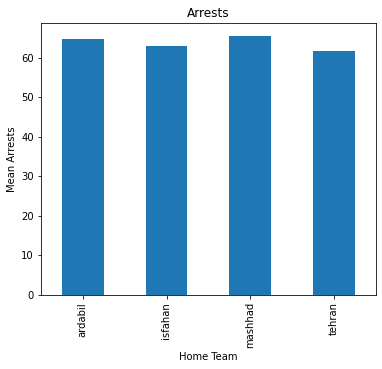

In [279]:
n_words_per_city.plot(kind='bar', title='Arrests', ylabel='Mean Arrests',
                      xlabel='Home Team', figsize=(6, 5))

### Number of  per description

In [280]:
sentence_tokenizer = SentenceTokenizer()

In [287]:
# calculate number of words per description
posts['n_sentences'] = posts.Description.apply(
    lambda desc: len(sentence_tokenizer.tokenize(desc))
)

In [288]:
n_sentences_per_city = posts.groupby(['city'])['n_sentences'].mean()

<AxesSubplot:title={'center':'Arrests'}, xlabel='Home Team', ylabel='Mean Arrests'>

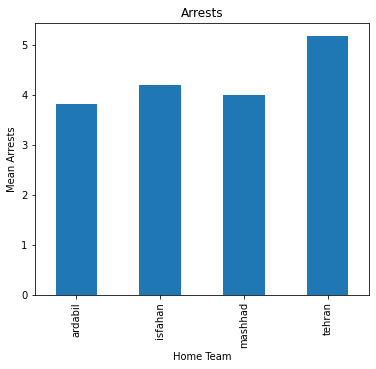

In [289]:
n_sentences_per_city.plot(kind='bar', title='Arrests', ylabel='Mean Arrests',
                          xlabel='Home Team', figsize=(6, 5))

### Most common words